In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os
import unicodedata
import string
import torch

In [2]:
# 用于过滤掉unciode字符串中不属于英文字符的字符
all_letters = string.ascii_letters+".,;'-"
 
def findFiles(path):
    return glob.glob(path)
 
# 将Unicode编码转换成ASCII编码
def unicodeToAscii(s):
    # 'Mn'表示非间距组合记号
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letters)
 
# 读取文件并分成几行
def readLines(filename):
    lines = open(filename,encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]
 
# 构建category_lines字典，列表中的每行是一个类别
category_lines = {}
all_categories = []
 
for filename in findFiles("./names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    #print(lines)
    # 保存成字典：key对应类别，value对应的语种的语料
    category_lines[category] = lines
    
n_categories = len(all_categories)
print(n_categories) # 语种数量
 
if n_categories == 0:
    raise RuntimeError("Please download your data!")
print(f"Total categories:{n_categories}:{all_categories}")

5
Total categories:5:['family', 'female', 'male', 'names', 'pet']


In [3]:
import random

In [4]:
# 列表中的随机项
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]
 
def randomTrainingPair():
    # 随机抽取语言
    category = randomChoice(all_categories)
    # 对语言随机抽取名字
    line = randomChoice(category_lines[category])
    #print(f"{category}:{line}")
    return category,line
 
# 类别的one-hot张量
def categoryTensor(category):
    # 获得语种列表中对应语种的索引值
    index = all_categories.index(category)
    # 构造one-hot张量:除了对应语种的值为1，其余都为0
    tensor = torch.zeros(1,n_categories)
    tensor[0][index] = 1
    return tensor
 
# 构造成对数据：（A,B）(B,C)(C,D)(D,<EOS>)
# 用于输入的从头到尾字母（不包含EOS）的one-hot张量
n_letters = len(all_letters)+1 # 添加EOS结束位
def inputTensor(line):
    # 第二维度代表逐个字母输入
    tensor = torch.zeros(len(line),1,n_letters) # n_letters：58
    # 对该单词line的每个字母遍历转换成one-hot张量
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor
 
# 用于生成目标张量
def targetTensor(line):
    # 从第二个字母开始
    letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters-1) # 添加EOS结束位
    return torch.LongTensor(letter_indexes)
 
# 构建训练集
def randomTrainingExample():
    #选择类别和对应的语料
    category,line = randomTrainingPair()
    # 将类别转成one-hot
    category_tensor = categoryTensor(category)
    # 将输入数据转成one-hot
    input_line_tensor = inputTensor(line)
    #print(input_tensor[0])
    # 标签转换
    target_line_tensor = targetTensor(line)
    #print(target.shape)
    return category_tensor,input_line_tensor,target_line_tensor
 
category_tensor,input_line_tensor,target_line_tensor = randomTrainingExample()

In [5]:
import torch
import torch.nn as nn

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        # 三层核心结构
        self.i2h = nn.Linear(n_categories+input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories+input_size+hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size+output_size,output_size)
        # 防止过拟合，softmax对输出归一化
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
 
    def forward(self,category,input,hidden):
        # 合并所有输入
        input_combined = torch.cat((category,input,hidden),1)
        # 得到隐藏层
        hidden = self.i2h(input_combined)
        # 得到当前隐藏的字母信息
        output = self.i2o(input_combined)
        # 合并
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden
    
    # 随机初始化h0
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    
# 调用RNN模型
print(n_letters)
rnn = RNN(n_letters,128,n_letters)
#trnn = nn.RNN(input_size=100, hidden_size=100, num_layers=1)
print(rnn)
#print(trnn)

58
RNN(
  (i2h): Linear(in_features=191, out_features=128, bias=True)
  (i2o): Linear(in_features=191, out_features=58, bias=True)
  (o2o): Linear(in_features=186, out_features=58, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [7]:
import time
import math
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
import string
import unicodedata
import glob
import random
import time
import math

In [28]:
# 创建一个TensorBoard的SummaryWriter，将日志写入到./logs目录下
#writer = SummaryWriter("./logs")
criterion = nn.NLLLoss()
learning_rate = 0.001
#optimizer = torch.optim.SGD(rnn.parameters(), learning_rate)
#momentum weight_decay
optimizer = torch.optim.Adam(rnn.parameters(), learning_rate)
def train(category_tensor,input_line_tensor,target_line_tensor):#, iteration):
    rnn.train()
    # 在target最后添加一维
    target_line_tensor.unsqueeze_(-1)
    # 初始化隐藏状态
    hidden = rnn.initHidden()
    # 每输入一个单词，清理一次梯度累积
    rnn.zero_grad()
 
    loss = 0
    # 遍历该单词的所有字母
    for i in range(input_line_tensor.size(0)):
        # 返回hidden用于循环的下一步骤
        output,hidden = rnn(category_tensor,input_line_tensor[i],hidden)
        # 使用 torch.clamp 防止数值溢出
        clamped_output = torch.clamp(output, min=-1e6, max=1e6)

        l = criterion(clamped_output,target_line_tensor[i])
        if torch.isnan(l).any():
            print("find nan")
            l = np.nan_to_num(l)
        loss += l
    optimizer.zero_grad()
    loss.backward()
    # 梯度裁剪
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1.0)
    optimizer.step()
    # 每个iteration将损失写入TensorBoard
    #writer.add_scalar("Training Loss", loss.item(), iteration)
    if input_line_tensor.size(0) == 0:
        print("find zero")
    return output,loss.item() / max([input_line_tensor.size(0),1])
 
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return f'%dm %ds' %(m,s)
 
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
# 每500次保留平均损失loss值后重置为0
total_loss = 0
 
start = time.time()
for iter in range(1,n_iters+1):
    output,loss = train(*randomTrainingExample())#, iter)
    total_loss += loss
 
    if iter % print_every == 0:
        print("%s (%d %d%%) %.4f" %(timeSince(start),iter,iter/n_iters*100,loss))
 
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
# 训练结束后关闭SummaryWriter
#writer.close()
model_dir = "./model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# 保存模型
torch.save(rnn,"./model/rnnmodel.pth")

1m 24s (5000 5%) 2.8848
2m 57s (10000 10%) 2.9417
4m 27s (15000 15%) 2.1860
6m 14s (20000 20%) 2.1193
7m 35s (25000 25%) 2.3089
8m 55s (30000 30%) 0.4323
10m 19s (35000 35%) 0.8238
11m 48s (40000 40%) 3.3568
13m 12s (45000 45%) 2.1496
14m 41s (50000 50%) 1.8262
16m 7s (55000 55%) 2.1153
17m 32s (60000 60%) 2.9227
19m 11s (65000 65%) 1.8286
20m 37s (70000 70%) 2.4555
22m 7s (75000 75%) 2.6439
23m 33s (80000 80%) 1.9871
25m 2s (85000 85%) 2.6546
26m 32s (90000 90%) 2.0796
28m 9s (95000 95%) 0.9747
29m 37s (100000 100%) 2.8853


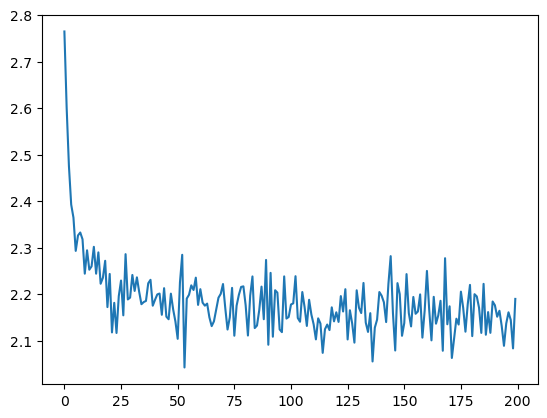

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

In [21]:
#加载模型(不用训练上面两行)
rnn=torch.load('./model/rnnmodel.pth')
# 测试
max_length = 20
 
# 来自类别和首字母的样本
def sample(category,start_letter="A"):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
 
        output_name = start_letter
 
        for i in range(max_length):
            output,hidden = rnn(category_tensor,input[0],hidden)
            # 采用可视化技术，绘制出模型为每个时刻预测的前5个最可能的候选字母。 
            # top函数用来提取最大概率的值和索引，也可以用torch.max函数
            # topv,topi = output.topk(1)
            # topi = topi[0][0]
            #print("output", output)
            #print("hidden", hidden)
            _,pred = torch.max(output.data,dim=1)
            topi = pred

            # 如果预测为EOS的索引，则跳出循环
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            
            # 当前预测的字母作为下一个时刻的输入
            input = inputTensor(letter)
        return output_name
    
# 从一个类别和多个首字母中获取多个样本
def samples(category,start_letters='ABC',num=1):
    print("我将为您生成满足您要求的名字：")
    for start_letter in start_letters:
        name1 = sample(category,start_letter)
        name = []
        name.append(name1)
        
        for i in range(num-1):
            i_name = sample(category,start_letter)
            #print("新生成的：",i_name)
            for get_name in name:
                #print("已有的名字：",get_name)
                j = 0
                while (get_name == i_name) and (j < 50):
                    i_name = sample(category,start_letter)
                    j += 1
            name.append(i_name)
        if len(name) != num:
            print("抱歉，我不能找到足够满足您要求的以", start_letter, "开头的名字")
        for n in name:
            print(n)
        
def switch_lebel(argument):
    if argument == 0:
        lebel = "names"
    elif argument == 1:
        lebel = "family"
    elif argument == 2:
        lebel = "male"
    elif argument == 3:
        lebel = "female"
    elif argument == 4:
        lebel = "pet"
    else:
        # 默认操作
        lebel = "names"
        print("无效输入，默认您没有要求")
    return lebel

a = 1
while a == 1:
    print("0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 ")
    try:
        lebel_num = int(input("请告诉我你想要获取的name类型并输入相应的字符："))
        pass
    except ValueError:
        lebel_num = -1
        pass
    lebel = switch_lebel(lebel_num)
    data = input("请告诉我你想要的开头字母，可以有多个，连续大写输入即可：")
    try:
        num = int(input("请告诉我对每个首字母，你想生成几个name："))
        pass
    except ValueError:
        num = 1
        print("无效输入，默认生成一个")
        pass
    samples(lebel, data, num)        
    try:
        a = int(input("生成完毕，0 退出，1 继续："))
        pass
    except ValueError:
        a = -1
        pass
    if a != 0 and a != 1:
        print("无效输入，默认退出")
print("感谢使用")

0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 
请告诉我你想要获取的name类型并输入相应的字符：0
请告诉我你想要的开头字母，可以有多个，连续大写输入即可：A
请告诉我对每个首字母，你想生成几个name：1
我将为您生成满足您要求的名字：
Alles
生成完毕，0 退出，1 继续：1
0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 
请告诉我你想要获取的name类型并输入相应的字符：1
请告诉我你想要的开头字母，可以有多个，连续大写输入即可：ASD
请告诉我对每个首字母，你想生成几个name：3
我将为您生成满足您要求的名字：
Ardon
Ardellog
Argin
Shelly
Shanna
Shannar
Dusty
Desty
Danna
生成完毕，0 退出，1 继续：1
0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 
请告诉我你想要获取的name类型并输入相应的字符：f
无效输入，默认您没有要求
请告诉我你想要的开头字母，可以有多个，连续大写输入即可：f
请告诉我对每个首字母，你想生成几个name：f
无效输入，默认生成一个
我将为您生成满足您要求的名字：
fry
生成完毕，0 退出，1 继续：f
无效输入，默认退出
感谢使用
